# Gyms in Stockholm and Gothenburg
Link to interactive notebook: <https://colab.research.google.com/drive/1j5zdWqWcKbAZ6aKqMnZ0ZTl2mpzhmiZe>

**Import dependencies:**

In [0]:
!pip install geocoder

In [0]:
import pandas as pd
import folium
import requests
import geocoder
from getpass import getpass
import geopy.distance
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import math
import matplotlib.pyplot as plt

**Enter Foursquare developer API keys:**

In [0]:
client_id = getpass('Foursquare client ID:')
client_secret = getpass('Foursquare secret:')

Foursquare client ID:··········
Foursquare secret:··········


**Get ID of the gym category:**

In [0]:
VERSION = '20200425'
LIMIT = 100

In [0]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    client_id,
    client_secret,
    VERSION)
categories = requests.get(url).json()['response']['categories']

In [0]:
def find_category(name, categories):
    for category in categories:
        if category['name'] == name:
            return category
        child_category = find_category(name, category['categories'])
        if child_category != None:
            return child_category
    return None

In [0]:
gym_category = find_category('Gym / Fitness Center', categories)
gym_category_id = gym_category['id']

**Get gyms in Stockholm and Gothenburg:**

In [0]:
def clean_gym_name(name):
    if 'Friskis & Svettis' in name or 'Friskis och Svettis' in name:
        return 'Friskis & Svettis'
    if 'SATS' in name:
        return 'SATS'
    return name

In [0]:
def get_gyms_in_city(city_name):
    url = 'https://api.foursquare.com/v2/search/recommendations?&client_id={}&client_secret={}&v={}&categoryId={}&near={}&limit={}'.format(
        client_id, 
        client_secret, 
        VERSION, 
        gym_category_id,
        city_name,
        LIMIT)
    results = requests.get(url).json()['response']['group']['results']
    df = pd.DataFrame(((r['venue']['name'], r['venue']['location']['lat'], r['venue']['location']['lng']) for r in results), columns=['Name', 'Latitude', 'Longitude'])
    df['Name'] = df['Name'].apply(clean_gym_name)
    return df

In [0]:
gyms_in_stockholm = get_gyms_in_city('Stockholm')
gyms_in_gothenburg = get_gyms_in_city('Göteborg')

In [0]:
gyms_in_stockholm

,Name,Latitude,Longitude
0,SATS,59.332544,18.060433
1,SATS,59.292502,18.078312
2,SATS,59.341746,18.064223
3,SATS,59.315911,18.032368
4,Balance City,59.335550,18.072480
...,...,...,...
95,SATS,59.311869,18.057431
96,CrossFit Medis,59.315661,18.069925
97,Puls & Träning,59.358949,18.092658
98,Itrim,59.331476,18.028663


In [0]:
gyms_in_gothenburg

,Name,Latitude,Longitude
0,SATS,57.698283,11.941936
1,Skatås Gym & Motionscentrum,57.704591,12.033875
2,Fysiken,57.681740,11.983453
3,Hagabadet Gym & Fitness,57.699841,11.956567
4,SATS,57.705563,11.970659
...,...,...,...
95,Itrim,57.680221,12.002497
96,Fighter Centre Göteborg AB,57.695862,11.966187
97,Nordic Wellness,57.836649,12.299392
98,Bikram Yoga Göteborg,57.709350,11.964233


**Center coordinates of the cities:**

In [0]:
coordinate_stockholm = geocoder.arcgis('Stockholm, Sweden').latlng
coordinate_gothenburg = geocoder.arcgis('Göteborg, Sweden').latlng

**Plot the gyms on maps:**

In [0]:
my_map = folium.Map(location=coordinate_stockholm, zoom_start=12)

# Add markers to map
for lat, lng, name in zip(gyms_in_stockholm['Latitude'], gyms_in_stockholm['Longitude'], gyms_in_stockholm['Name']):
    popup = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(my_map)  
    
my_map

In [0]:
my_map = folium.Map(location=coordinate_gothenburg, zoom_start=12)

# Add markers to map
for lat, lng, name in zip(gyms_in_gothenburg['Latitude'], gyms_in_gothenburg['Longitude'], gyms_in_gothenburg['Name']):
    popup = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(my_map)  
    
my_map

**Clustered by their coordinates:**

In [0]:
kclusters = 5

def draw_clustered_map(gyms, center_coordinate):
    coordinates = gyms[['Latitude', 'Longitude']]

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(coordinates)

    # create map
    map_clusters = folium.Map(location=center_coordinate, zoom_start=12)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, name, cluster in zip(gyms['Latitude'], gyms['Longitude'], gyms['Name'], kmeans.labels_):
        cluster = cluster
        if math.isnan(cluster):
            cluster = 1.0
        cluster = int(cluster)
        label = folium.Popup(name + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='#000000',
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=1).add_to(map_clusters)
          
    return map_clusters

In [28]:
draw_clustered_map(gyms_in_stockholm, coordinate_stockholm)

In [29]:
draw_clustered_map(gyms_in_gothenburg, coordinate_gothenburg)

**Calculate density:**

In [0]:
def calculate_density(gyms):
    upper_left_corner = min(gyms['Longitude']), max(gyms['Latitude'])
    lower_left_corner = min(gyms['Longitude']), min(gyms['Latitude'])
    lower_right_corner = max(gyms['Longitude']), min(gyms['Latitude'])
    width = geopy.distance.vincenty(lower_left_corner, lower_right_corner).km
    height = geopy.distance.vincenty(lower_left_corner, upper_left_corner).km
    area = width * height
    density = len(gyms) / area
    return width, height, area, density

density_stockholm = calculate_density(gyms_in_stockholm)
density_gothenburg = calculate_density(gyms_in_gothenburg)

In [0]:
def print_stats(city, stats):
    print('### {}'.format(city))
    print('Width: {:.2f} km, Height: {:.2f} km, Area: {:.2f} km2, Density: {:.2f}/km2'.format(*stats))

print_stats('Stockholm', density_stockholm)
print_stats('Gothenburg', density_gothenburg)

### Stockholm
Width: 29.09 km, Height: 17.43 km, Area: 507.25 km2, Density: 0.20/km2
### Gothenburg
Width: 59.96 km, Height: 26.91 km, Area: 1613.54 km2, Density: 0.06/km2


**Most popular gym chains:**

In [0]:
def get_chains(gyms):
    grouped_gyms = gyms.groupby('Name').count()
    grouped_gyms = grouped_gyms.rename(columns={'Latitude': 'Count'})
    grouped_gyms = grouped_gyms.drop(labels=['Longitude'], axis=1)
    chains = grouped_gyms[grouped_gyms['Count'] > 1]
    chains = chains.sort_values(by='Count', ascending=False)
    return chains

In [0]:
chains_in_stockholm = get_chains(gyms_in_stockholm)
chains_in_stockholm

,Count
Name,
SATS,26
Puls & Träning,15
Friskis & Svettis,11
Fitness24Seven,7
Nordic Wellness,4
Actic,3


In [0]:
chains_in_gothenburg = get_chains(gyms_in_gothenburg)
chains_in_gothenburg

,Count
Name,
Nordic Wellness,34
Fitness24Seven,10
SATS,9
Friskis & Svettis,7
STC,6
Puls & Träning,3
Fysiken,2


In [0]:
def make_bar_chart(chains):
    x = np.arange(chains.shape[0])
    y = chains['Count'].tolist()
    ticks = chains.index.tolist()

    plt.subplots(figsize=(18,5))
    plt.bar(x, y, align='center', alpha=1)
    plt.xticks(x, ticks)
    plt.ylabel('Number of gyms')
    plt.title('Chains with most gyms')

    plt.show()

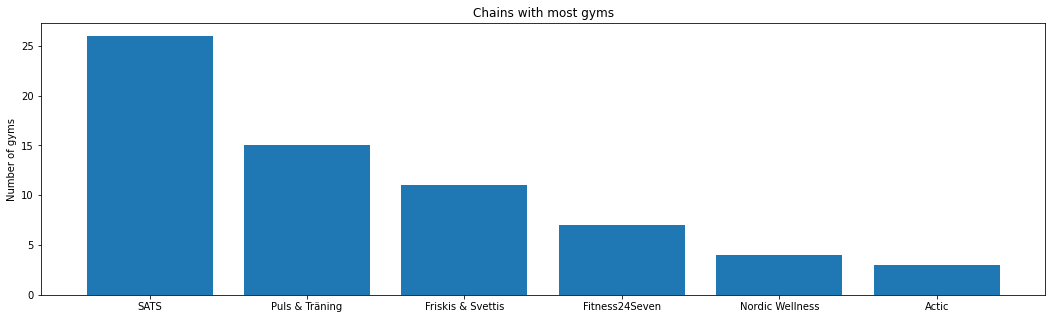

In [0]:
make_bar_chart(chains_in_stockholm)

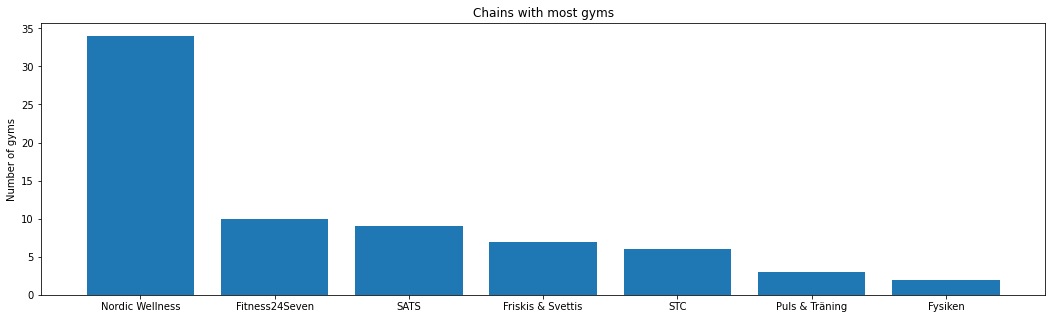

In [0]:
make_bar_chart(chains_in_gothenburg)